<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter05/Detectron2_Chapter05_Data_Processing.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 05-Data Processing
## The dataset

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/datasets/braintumors.zip?raw=true -O braintumors.zip

In [ ]:
!unzip braintumors.zip -d braintumors

replace braintumors/axial_t1wce_2_class/axial_t1wce_2_class.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
import os
data_folder = "braintumors"
data_folder_yolo = data_folder + "_yolo"
data_folder_coco = data_folder + "_coco"
folders = os.listdir("braintumors")
print(folders)

['coronal_t1wce_2_class', 'sagittal_t1wce_2_class', 'axial_t1wce_2_class']


In [ ]:
!sudo apt-get install tree

[sudo] password for pham: 


In [ ]:
!tree braintumors/ -d

braintumors/
├── axial_t1wce_2_class
│   ├── images
│   │   ├── test
│   │   └── train
│   └── labels
│       ├── test
│       └── train
├── coronal_t1wce_2_class
│   ├── images
│   │   ├── test
│   │   └── train
│   └── labels
│       ├── test
│       └── train
└── sagittal_t1wce_2_class
    ├── images
    │   ├── test
    │   └── train
    └── labels
        ├── test
        └── train

21 directories


In [ ]:
from glob import glob
def count_yolo_data(folder):
  for images_labels in ["images", "labels"]:
    for train_test in ["train", "test"]:
      file_ext = "*.jpg" if images_labels == "images" else "*.txt"
      p = os.path.join(folder, images_labels, train_test, file_ext)
      files = glob(p)
      print(train_test, images_labels, len(files))

In [ ]:
for folder in folders:
  print("-"*8 + folder + "-"*8)
  folder = os.path.join(data_folder, folder)
  count_yolo_data(folder)

--------coronal_t1wce_2_class--------
train images 319
test images 78
train labels 318
test labels 78
--------sagittal_t1wce_2_class--------
train images 264
test images 70
train labels 264
test labels 70
--------axial_t1wce_2_class--------
train images 310
test images 75
train labels 296
test labels 75


## Move data

In [ ]:
import os
import shutil
from tqdm import tqdm
# move all into one folder
def copy_yolo_files(from_folder, to_folder, images_labels, train_test):
  from_path = os.path.join(from_folder, images_labels, train_test)
  to_path = os.path.join(to_folder, images_labels, train_test)
  os.makedirs(to_path, exist_ok = True)
  # get files
  file_ext = "*.jpg" if images_labels == "images" else "*.txt"
  files = glob(os.path.join(from_path,file_ext))
  # move files
  for file in tqdm(files):
    shutil.copy(file, to_path)

In [ ]:
# copy
for from_folder in folders:
  from_folder = os.path.join(data_folder, from_folder)
  to_folder = data_folder_yolo
  for images_labels in ["images", "labels"]:
    for train_test in ["train", "test"]:
      copy_yolo_files(from_folder, to_folder, images_labels, train_test)

100%|██████████| 75/75 [00:00<00:00, 11001.36it/s]


In [ ]:
# Now the folder should look like
!tree -d {data_folder_yolo}

braintumors_yolo
├── images
│   ├── test
│   └── train
└── labels
    ├── test
    └── train

6 directories


In [ ]:
# do the counting just to make sure
count_yolo_data(data_folder_yolo)

train images 893
test images 223
train labels 878
test labels 223


In [ ]:
# read the yaml file and write the class file
import yaml
from yaml.loader import SafeLoader

# Open the file and load the file
with open(os.path.join(data_folder, folders[0], folders[0]+'.yaml')) as f:
  classes = yaml.load(f, Loader=SafeLoader)["names"]
# Write classes.txt
with open(os.path.join(data_folder_yolo, "classes.txt"), "w") as f:
  f.write('\n'.join(classes))

## Data conversion

In [ ]:
!pip install -q pylabel

In [ ]:
from pylabel import importer
def yolo_to_coco(input_folder, output_folder, train_test):
  labels_path = os.path.join(input_folder, "labels", train_test)
  images_path = os.path.join(input_folder, "images", train_test)
  coco_dir = os.path.join(output_folder, train_test)
  os.makedirs(coco_dir, exist_ok=True)

  txt_files = glob(os.path.join(labels_path, "*.txt"))
  img_files = glob(os.path.join(images_path, "*.jpg"))
  # copy annotations
  for f in tqdm(txt_files):
    shutil.copy(f, coco_dir)
  # copy images
  for f in tqdm(img_files):
    shutil.copy(f, coco_dir)
  # get the classes
  with open(os.path.join(input_folder, "classes.txt"), "r") as f:
    classes = f.read().split("\n")
  
  # load dataset
  dataset = importer.ImportYoloV5(path=coco_dir, cat_names=classes, name="brain tumors")
  # export
  coco_file = os.path.join(coco_dir, "_annotations.coco.json")
  # Detectron requires starting index from 1
  dataset.export.ExportToCoco(coco_file, cat_id_index=1)
  # now delete yolo annotations in coco set
  for f in txt_files:
    os.remove(f.replace(labels_path, coco_dir))

In [ ]:
# May need to upgrade numpy version
# import pandas as pd
# print(pd.__version__)
# import numpy as np
# print(np.__version__)

In [ ]:
yolo_to_coco(data_folder_yolo, data_folder_coco, "train")
yolo_to_coco(data_folder_yolo, data_folder_coco, "test")

100%|██████████| 893/893 [00:00<00:00, 9836.42it/s]


In [ ]:
!tree -d {data_folder_coco}

braintumors_coco
├── test
└── train

2 directories


## Displaying Samples
Installation

In [ ]:
!python -m pip install \
'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ujo52zk8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ujo52zk8
  Resolved https://github.com/facebookresearch/detectron2.git to commit e39b8d0e6a5d17f713b20061b9cfc30f92213a5a
  Preparing metadata (setup.py) ... - done


In [ ]:
from detectron2.data.datasets import register_coco_instances
# Some configurations
name_ds = "braintumors_coco"
name_ds_train = name_ds + "_train"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_test = name_ds + "/test/" + af

# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )
## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


Test some registered datasets

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random
random.seed(42)
import cv2
import matplotlib.pyplot as plt

def plot_random_samples(name_ds, n=3):
  # access
  ds = DatasetCatalog.get(name_ds)
  met = MetadataCatalog.get(name_ds)
  # plot (arrange in 3x3)
  nrows = int(-(-n/3)) # ceil
  ncols = 3
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
  for i,s in enumerate(random.sample(ds, n)):
    ax = axs[i//ncols][i%ncols] if len(axs.shape) == 2 else axs[i]
    img = cv2.imread(s["file_name"])
    v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5)
    v = v.draw_dataset_dict(s)
    ax.imshow(v.get_image())
    ax.axis("off")
  plt.tight_layout()
  plt.show()

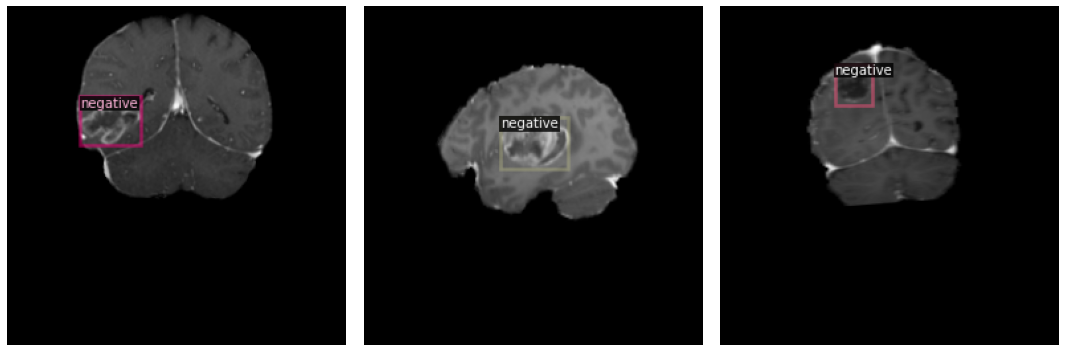

In [ ]:
plot_random_samples(name  _ds_train, n = 3)

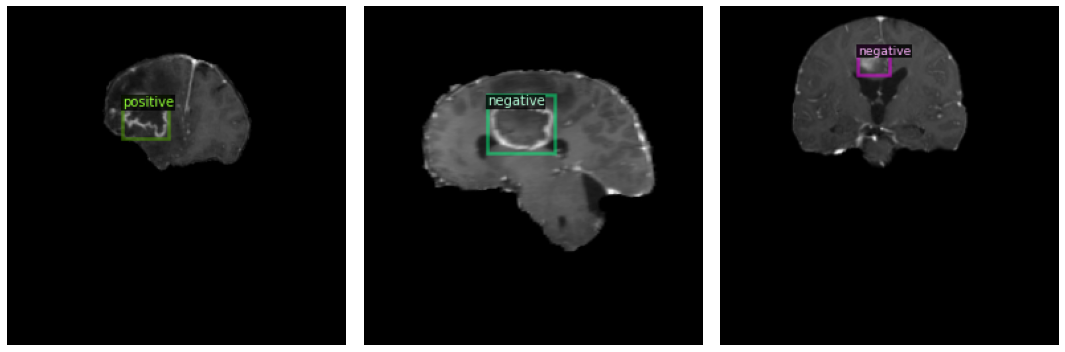

In [ ]:
plot_random_samples(name_ds_test, n = 3)